In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [ ]:
class GigachadModel(nn.Module):
    def __init__(self):
        super(GigachadModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(25088, 64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(32, 10)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return torch.log_softmax(x, dim=1)

In [ ]:
def calculate_metrics(loader, model):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, precision, f1

In [ ]:
net = GigachadModel()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
writer = SummaryWriter()

history = {
    'score_train': [],
    'score_test': [],
    'accuracy_train': [],
    'accuracy_test': [],
    'epochs': [],
}


for epoch in range(30):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}')

    train_acc, train_rec, train_prec, train_f1 = calculate_metrics(trainloader, net)
    print(f'Training - Accuracy: {train_acc}, Recall: {train_rec}, Precision: {train_prec}, F1 Score: {train_f1}')

    val_acc, val_rec, val_prec, val_f1 = calculate_metrics(valloader, net)
    print(f'Validation - Accuracy: {val_acc}, Recall: {val_rec}, Precision: {val_prec}, F1 Score: {val_f1}')


    history['score_train'].append(train_f1)
    history['score_test'].append(val_f1)
    history['accuracy_train'].append(train_acc)
    history['accuracy_test'].append(val_acc)
    history['epochs'].append(epoch)

print('Finished Training')

Epoch 1, Loss: 1.088
Training - Accuracy: 0.8693333333333333, Recall: 0.8693333333333333, Precision: 0.8701276680593519, F1 Score: 0.8633624660874262
Validation - Accuracy: 0.8536, Recall: 0.8535999999999999, Precision: 0.8528032661892248, F1 Score: 0.8472160061236961
Epoch 2, Loss: 0.671
Training - Accuracy: 0.8936166666666666, Recall: 0.8936166666666667, Precision: 0.894050105382574, F1 Score: 0.8907692596037217
Validation - Accuracy: 0.8788, Recall: 0.8788, Precision: 0.8783486632898532, F1 Score: 0.8754158096589755
Epoch 3, Loss: 0.559
Training - Accuracy: 0.9055833333333333, Recall: 0.9055833333333334, Precision: 0.9073400975820757, F1 Score: 0.9030571054882379
Validation - Accuracy: 0.8847, Recall: 0.8846999999999999, Precision: 0.886625780954646, F1 Score: 0.8818719092375942
Epoch 4, Loss: 0.481
Training - Accuracy: 0.9207, Recall: 0.9206999999999999, Precision: 0.9206886973415205, F1 Score: 0.9197278605424973
Validation - Accuracy: 0.8969, Recall: 0.8969000000000001, Precision:

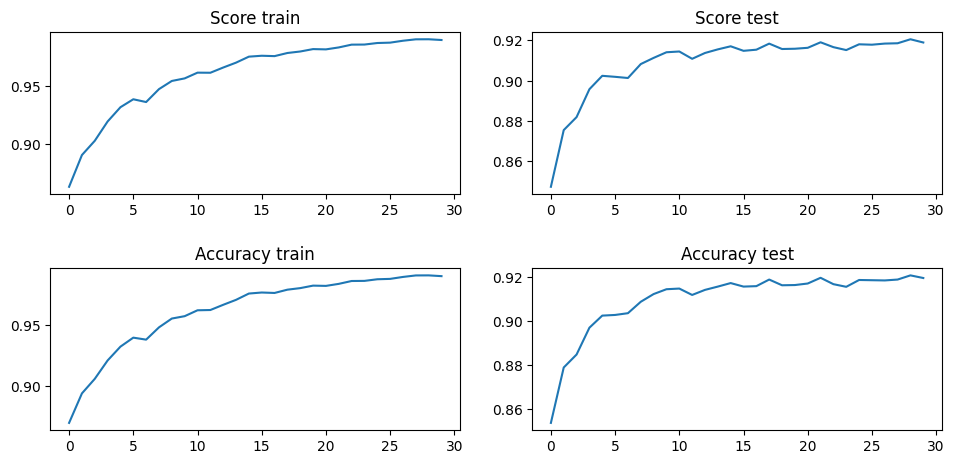

In [ ]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(history['epochs'], history['score_train'])
ax[0, 0].set_title('Score train')

ax[0, 1].plot(history['epochs'], history['score_test'])
ax[0, 1].set_title('Score test')

ax[1, 0].plot(history['epochs'], history['accuracy_train'])
ax[1, 0].set_title('Accuracy train')

ax[1, 1].plot(history['epochs'], history['accuracy_test'])
ax[1, 1].set_title('Accuracy test')

fig.tight_layout(pad=2.0)

plt.show()

In [ ]:
!pip install onnx

input_onnx = torch.randn(32, 1, 28, 28, requires_grad=True)

input_onnx = input_onnx.to(device)

torch.onnx.export(
    net,
      input_onnx,
      "fashionMnistClassifier.onnx",
      export_params=True,
      opset_version=10,
      do_constant_folding=True,
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 45.2 MB/s eta 0:00:00
